In [ ]:
import pandas as pd

clinvar_df = pd.read_csv('ClinVar.tsv', sep='\t')
lovd_df = pd.read_csv('LOVD.tsv', sep='\t')

<ipython-input-202-31363c537781>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv('ClinVar.tsv', sep='\t')


In [ ]:

clinvar_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
lovd_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']


In [ ]:
# prompt: the ID column of both clinvar_df and lovd_df are <db_name>.<gene_name><zero padded 5 digits>, for each entry in both, create a column named gene that includes the gene name, make sure to not use 0 to split as the 0 padding may contain 1 at the very end, so just remove the last 5

def extract_gene_name(id_value):
  parts = id_value.split('.')
  if len(parts) >= 2:
    return parts[1][:-5] #remove the last 5 characters
  else:
    return None

clinvar_df['gene'] = clinvar_df['ID'].apply(extract_gene_name)
lovd_df['gene'] = lovd_df['ID'].apply(extract_gene_name)


In [ ]:
# prompt: remove all rows in both that include negative values at column POS and report how many were deleted

deleted_clinvar = 0
deleted_lovd = 0

# Remove rows with negative POS values in clinvar_df
initial_clinvar_len = len(clinvar_df)
clinvar_df = clinvar_df[clinvar_df['POS'] >= 0]
deleted_clinvar = initial_clinvar_len - len(clinvar_df)

# Remove rows with negative POS values in lovd_df
initial_lovd_len = len(lovd_df)
lovd_df = lovd_df[lovd_df['POS'] >= 0]
deleted_lovd = initial_lovd_len - len(lovd_df)

print(f"Number of rows deleted from clinvar_df: {deleted_clinvar}")
print(f"Number of rows deleted from lovd_df: {deleted_lovd}")




Number of rows deleted from clinvar_df: 2235
Number of rows deleted from lovd_df: 0


In [ ]:
# prompt: For each row, split the semicolon-delimited INFO column into three separate columns: the embedded variant ID (ID), the consequence annotation (CONSEQ), and the free-text “REPORTED” status. only retain CONSEQ (str) and REPORTED (int)

import pandas as pd

# Assuming clinvar_df and lovd_df are already defined as in the provided code

def process_info_column(df):
    """Splits the INFO column and retains CONSEQ and REPORTED."""

    def extract_info(info_str):
        try:
            id_val, conseq_val, reported_val = info_str.split(';')

            # Extract the desired values, handling potential errors gracefully
            conseq = conseq_val.split('=')[1] if '=' in conseq_val else None
            reported = int(reported_val.split('=')[1]) if '=' in reported_val and reported_val.split('=')[1].isdigit() else None

            return conseq, reported
        except (ValueError, IndexError):
            return None, None

    df[['CONSEQ', 'REPORTED']] = df['INFO'].apply(extract_info).apply(pd.Series)
    df = df.drop('INFO', axis=1)
    df = df.dropna(subset=['CONSEQ', 'REPORTED'])  # Remove rows with missing CONSEQ or REPORTED

    return df


clinvar_df = process_info_column(clinvar_df)
lovd_df = process_info_column(lovd_df)


In [ ]:
# prompt: get the number of unique CONSEQ columns in both and print all variations

# Assuming clinvar_df and lovd_df are already processed as in the previous code

# Combine the CONSEQ columns from both DataFrames
combined_conseq = pd.concat([clinvar_df['CONSEQ'], lovd_df['CONSEQ']], ignore_index=True)

# Get unique CONSEQ values and their counts
unique_conseq_counts = combined_conseq.value_counts()

# Print the number of unique CONSEQ values
print(f"Number of unique CONSEQ values: {len(unique_conseq_counts)}")

# Print all variations of CONSEQ
print("\nAll variations of CONSEQ:")
unique_conseq_counts

Number of unique CONSEQ values: 139

All variations of CONSEQ:


,count
CONSEQ,
Uncertain significance,25680
Likely benign,18712
Pathogenic,11120
Conflicting classifications of pathogenicity,10597
nan,4575
...,...
"likely pathogenic (recessive), pathogenic, pathogenic (recessive)",1
"likely pathogenic, NA, pathogenic (recessive)",1
"likely benign, NA, pathogenic (recessive), VUS",1


In [ ]:
# prompt: find out how many entries in each dataset have the same CHROM POS REF ALT and put the combination that appears more than once in a non-unique-df for each original dataset that shows the combination and how many times it appears

def find_duplicate_entries(df):
    """
    Finds duplicate entries based on CHROM, POS, REF, and ALT columns,
    and returns a DataFrame with the duplicates and their counts.
    """

    duplicates = df.groupby(['CHROM', 'POS', 'REF', 'ALT']).size().reset_index(name='count')
    non_unique_df = duplicates[duplicates['count'] > 1]
    return non_unique_df

# Apply the function to each DataFrame
clinvar_non_unique_df = find_duplicate_entries(clinvar_df)
lovd_non_unique_df = find_duplicate_entries(lovd_df)

print("ClinVar Non-Unique Entries:")
print(clinvar_non_unique_df)

print("\nLOVD Non-Unique Entries:")
print(lovd_non_unique_df)

ClinVar Non-Unique Entries:
      CHROM       POS REF ALT  count
8045     17  56769736   C   T      2
8046     17  56769887   G   A      2
8047     17  56769902   G   A      2
8048     17  56769956   C   G      2
8049     17  56769957   G   T      2
...     ...       ...  ..  ..    ...
10086    17  56811599   C  CA      2
10087    17  56811608   C   G      2
10088    17  56811613   T   G      2
10089    17  56811623   T   C      2
10090    17  56811632   A   G      2

[2046 rows x 5 columns]

LOVD Non-Unique Entries:
      CHROM       POS                                                REF  \
5767     13  32929995                                                  c   
5905     13  32930731                                                  G   
6385     13  32937473                                                  G   
8182     13  32973012                                                  A   
10830    16  23646398                                                GGA   
11383    16  89645036

In [ ]:
# prompt: remove all none-unique entries retaining one copy of each in each database

def remove_non_unique_entries(df):
    """Removes non-unique entries from the DataFrame, keeping one copy of each."""

    # Group by the specified columns and keep only the first occurrence of each group
    df = df.groupby(['CHROM', 'POS', 'REF', 'ALT']).first().reset_index()
    return df

# Apply the function to each DataFrame
clinvar_df = remove_non_unique_entries(clinvar_df)
lovd_df = remove_non_unique_entries(lovd_df)

print("ClinVar DataFrame after removing non-unique entries:")
print(clinvar_df.shape)

print("\nLOVD DataFrame after removing non-unique entries:")
lovd_df.shape


ClinVar DataFrame after removing non-unique entries:
(73795, 10)

LOVD DataFrame after removing non-unique entries:


(19691, 10)

In [ ]:
def classify_conseq(value):
    terms = {v.strip().lower() for v in value.split(',')}
    has_pathogenic = any("pathogenic" in t for t in terms)
    has_benign = any("benign" in t for t in terms)

    if has_pathogenic and not has_benign:
        return "Pathogenic"
    elif has_benign and not has_pathogenic:
        return "Benign"
    elif has_benign and has_pathogenic:
        return "conflicting"
    else:
        return "Unknown"

lovd_df["CONSEQ"] = lovd_df["CONSEQ"].apply(classify_conseq)
lovd_df["CONSEQ"].value_counts()


,count
CONSEQ,
Unknown,8797
Pathogenic,6201
Benign,4612
conflicting,81


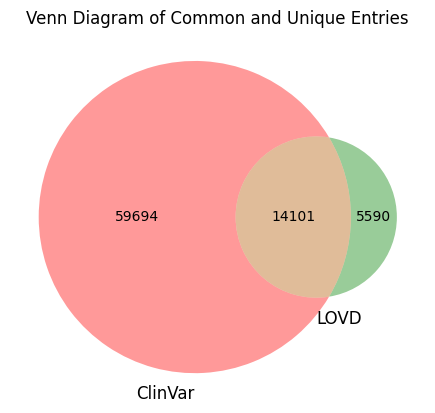

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 1) Venn diagram of overlap
clinvar_set = set(clinvar_df.apply(lambda r: tuple(r[['CHROM','POS','ALT','REF']]), axis=1))
lovd_set    = set(lovd_df   .apply(lambda r: tuple(r[['CHROM','POS','ALT','REF']]), axis=1))

intersection = clinvar_set & lovd_set
clinvar_only = clinvar_set - lovd_set
lovd_only    = lovd_set - clinvar_set

venn2(
    subsets=(len(clinvar_only), len(lovd_only), len(intersection)),
    set_labels=('ClinVar','LOVD')
)
plt.title("Venn Diagram of Common and Unique Entries")
plt.show()




22


In [ ]:
# 2) Merge, keeping ClinVar on overlap
keys = ['CHROM','POS','REF','ALT']

# suffix ClinVar columns with _c and LOVD with _l
merged = pd.merge(
    clinvar_df, lovd_df,
    on=keys, how='outer',
    suffixes=('_c','_l')
)

# get a list of all non-key columns in ClinVar
data_cols = [c for c in clinvar_df.columns if c not in keys]

# for each data column, prefer the ClinVar value, else fall back to LOVD
for col in data_cols:
    merged[col] = merged[f'{col}_c'].combine_first(merged[f'{col}_l'])

# now keep just the keys + your original ClinVar data columns
final = merged[keys + data_cols]



In [ ]:
merged_df = final

In [ ]:
# prompt: # Print the shapes of the resulting DataFrames
# print("Shape of ref_agree_alt_disagree_df:", ref_agree_alt_disagree_df.shape)
# print("Shape of alt_agree_ref_disagree_df:", alt_agree_ref_disagree_df.shape)
# print("Shape of neither_agree_df:", neither_agree_df.shape)
# save all three as csv

# Save the DataFrames to CSV files
ref_agree_alt_disagree_df.to_csv('ref_agree_alt_disagree.csv', index=False)
alt_agree_ref_disagree_df.to_csv('alt_agree_ref_disagree.csv', index=False)
neither_agree_df.to_csv('neither_agree.csv', index=False)
merged_df.to_csv('combined.csv', index=False)


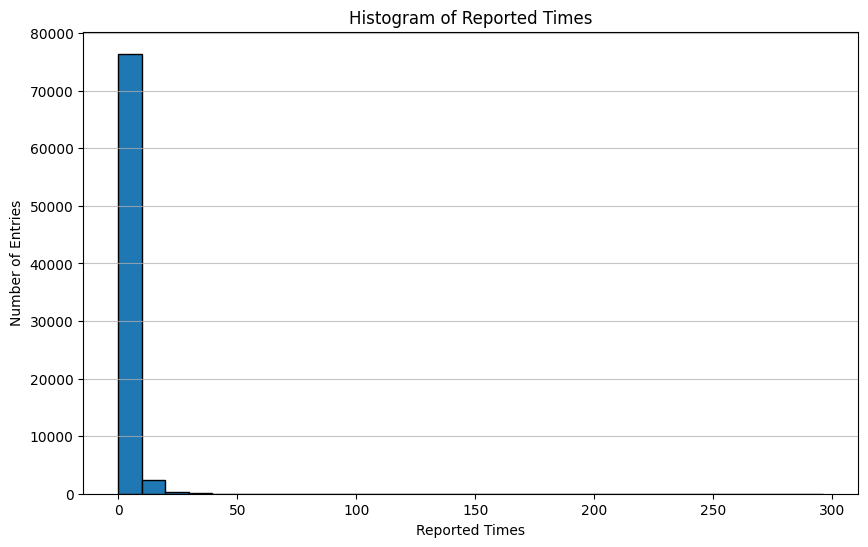

In [ ]:
# prompt: sort merged df by reported decreasing and plot a histogram of reported times (x axis) and how many entries were reported that many times

# Sort the merged DataFrame by the 'REPORTED' column in descending order
merged_df_sorted = merged_df.sort_values('REPORTED', ascending=False)

# Create a histogram of reported times
plt.figure(figsize=(10, 6))
plt.hist(merged_df_sorted['REPORTED'], bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Reported Times')
plt.ylabel('Number of Entries')
plt.title('Histogram of Reported Times')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
# prompt: read annotation from combined.hg19_multianno.tsv note field: (Otherinfo6), renamee it to ID and combine it with merged_df  field: (ID) on the specified fields do the merge, keep only entries that are common on that field

# Assuming 'merged_df' and the 'combined.hg19_multianno.tsv' file are available

import pandas as pd

# Read the annotation file
anno_df = pd.read_csv('finalAnnot.tsv', sep='\t')

# Extract the 'Otherinfo6' column and rename it to 'ID'
anno_df = anno_df.rename(columns={'Otherinfo6': 'ID'})



# Merge the two DataFrames on the 'ID' column, keeping only common entries
merged_df = pd.merge(merged_df, anno_df, on='ID', how='inner')

# Display the merged DataFrame
print(len(merged_df['gene'].value_counts()))



<ipython-input-227-a623c573477f>:8: DtypeWarning: Columns (0,120) have mixed types. Specify dtype option on import or set low_memory=False.
  anno_df = pd.read_csv('finalAnnot.tsv', sep='\t')


22


In [ ]:
category_map = {
    "Uncertain significance":                      "Unknown",
    "Likely benign":                               "Benign",
    "Benign":                                      "Benign",
    "Benign/Likely benign":                        "Benign",
    "Pathogenic":                                  "Pathogenic",
    "Likely pathogenic":                           "Pathogenic",
    "Pathogenic/Likely pathogenic":                "Pathogenic",
    "Likely pathogenic, low penetrance":           "Pathogenic",
    "Conflicting classifications of pathogenicity":"Unknown",
    "not provided":                                "Unknown",
    "-":                                           "Unknown",
    "no classification for the single variant":    "Unknown",
    "Unknown": "Unknown"
}


In [ ]:
# prompt: based on category_map, a dictionary, convert the entries in merged_df['CONSEQ']. for each entry as a key, find it's value from the dict

merged_df['CONSEQ'] = merged_df['CONSEQ'].map(category_map).fillna("Unknown")
merged_df['CONSEQ'].value_counts()
# final['CONSEQ'].value_counts()


,count
CONSEQ,
Unknown,42964
Benign,21999
Pathogenic,14422


In [ ]:
# prompt: percentage of merged_df['ID'].str[:2] == "LO" that are CONSEQ==Pathogenic

lo_variants = merged_df[merged_df['ID'].str[:2] == "LO"]
pathogenic_lo_variants = lo_variants[lo_variants['CONSEQ'] == "Unknown"]

percentage = (len(pathogenic_lo_variants) / len(lo_variants)) * 100 if len(lo_variants) > 0 else 0

print(f"Percentage of variants starting with 'LO' that are pathogenic: {percentage:.2f}%")


Percentage of variants starting with 'LO' that are pathogenic: 100.00%


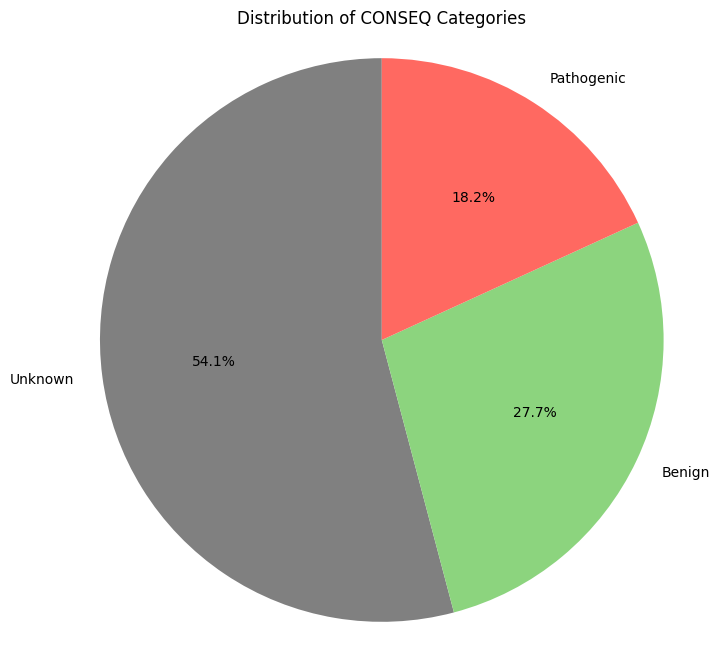

In [ ]:
# prompt: pie chart of merged_db based on conseq entries use these colors {'Pathogenic':'#FF6961','Benign':'#8CD47E','Unknown':'grey'}

import matplotlib.pyplot as plt

# Assuming merged_df is already defined and contains the 'CONSEQ' column

conseq_counts = merged_df['CONSEQ'].value_counts()
colors = {'Pathogenic':'#FF6961','Benign':'#8CD47E','Unknown':'grey'}

plt.figure(figsize=(8, 8))
plt.pie(conseq_counts, labels=conseq_counts.index, autopct='%1.1f%%', startangle=90, colors=[colors[label] for label in conseq_counts.index])
plt.title('Distribution of CONSEQ Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


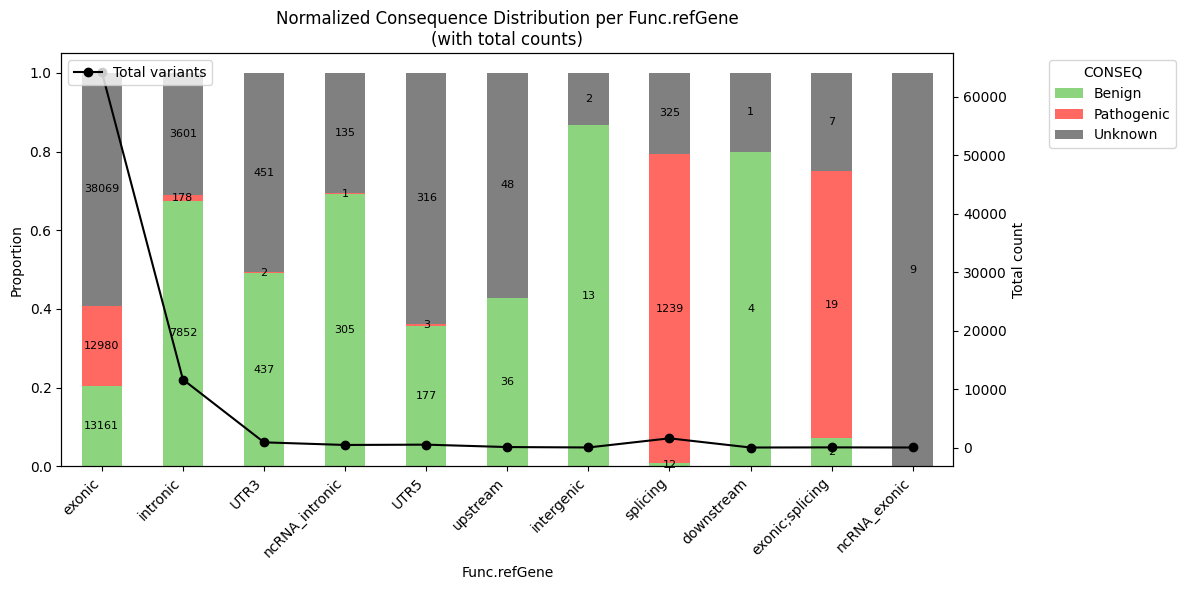

In [ ]:
import matplotlib.pyplot as plt

# (1) Grouping
grouped      = merged_df.groupby(['Func.refGene','CONSEQ']).size().unstack(fill_value=0)
grouped_sorted = grouped.sort_values(by=grouped.columns.tolist(), ascending=False)
grouped_normalized = grouped_sorted.div(grouped_sorted.sum(axis=1), axis=0)
totals = grouped_sorted.sum(axis=1)

# (2) Plot setup
fig, ax = plt.subplots(figsize=(12,6))
colors = {'Pathogenic':'#FF6961','Benign':'#8CD47E','Unknown':'grey'}
bar_container = grouped_normalized.plot(
    kind='bar', stacked=True,
    color=[colors.get(c, 'lightgrey') for c in grouped_normalized.columns],
    ax=ax
)

# (3) Add counts to each segment
for idx, row in enumerate(grouped_sorted.index):
    y_offset = 0
    for col in grouped_sorted.columns:
        val = grouped_sorted.loc[row, col]
        if val > 0:
            height = grouped_normalized.loc[row, col]
            ax.text(
                idx, y_offset + height / 2,
                str(val),
                ha='center', va='center', fontsize=8, color='black'
            )
            y_offset += height

# (4) Overlay totals as a line
ax2 = ax.twinx()
ax2.plot(
    range(len(totals)), totals.values,
    color='black', marker='o', linestyle='-',
    label='Total variants'
)
ax2.set_ylabel('Total count', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# (5) Final touches
ax.set_xlabel('Func.refGene')
ax.set_ylabel('Proportion')
ax.set_title('Normalized Consequence Distribution per Func.refGene\n(with total counts)')
ax.set_xticklabels(grouped_normalized.index, rotation=45, ha='right')
ax.legend(title='CONSEQ', bbox_to_anchor=(1.1,1))
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


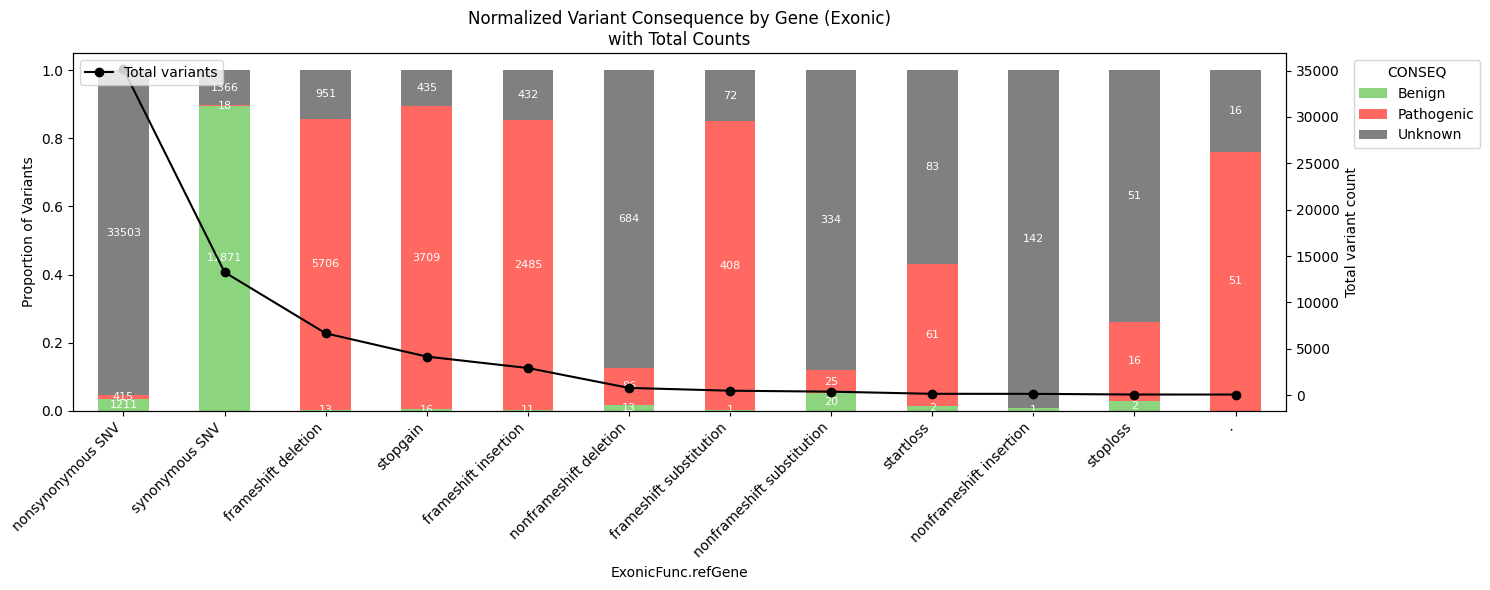

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for exonic variants
exonic_df = merged_df[merged_df['Func.refGene'] == 'exonic']

# Group by ExonicFunc.refGene and CONSEQ to get absolute counts
grouped_counts = exonic_df.groupby(['ExonicFunc.refGene', 'CONSEQ']).size().unstack(fill_value=0)

# Define colors for each consequence category
colors = {'Pathogenic': '#FF6961', 'Benign': '#8CD47E', 'Unknown': 'grey'}

# Sort by total variant count per gene
grouped_counts['Total'] = grouped_counts.sum(axis=1)
grouped_counts = grouped_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Normalize for plotting proportions
grouped_counts_normalized = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

# Plot normalized stacked bar chart
fig, ax = plt.subplots(figsize=(15, 6))
grouped_counts_normalized.plot(
    kind='bar', stacked=True,
    color=[colors[conseq] for conseq in grouped_counts_normalized.columns],
    ax=ax
)

# Annotate each segment with the absolute count
for idx, gene in enumerate(grouped_counts.index):
    bottom = 0
    for conseq in grouped_counts.columns:
        prop = grouped_counts_normalized.loc[gene, conseq]
        if prop > 0:
            count = grouped_counts.loc[gene, conseq]
            ax.text(
                idx,
                bottom + prop / 2,
                str(count),
                ha='center',
                va='center',
                fontsize=8,
                color='white'
            )
            bottom += prop

# Overlay the total counts as a line on a secondary y-axis
totals = grouped_counts.sum(axis=1)
ax2 = ax.twinx()
ax2.plot(
    range(len(totals)), totals.values,
    color='black', marker='o', linestyle='-',
    label='Total variants'
)
ax2.set_ylabel('Total variant count', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')

# Final plot adjustments
ax.set_xlabel('ExonicFunc.refGene')
ax.set_ylabel('Proportion of Variants')
ax.set_title('Normalized Variant Consequence by Gene (Exonic)\nwith Total Counts')
ax.set_xticklabels(grouped_counts.index, rotation=45, ha='right')
ax.legend(title='CONSEQ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


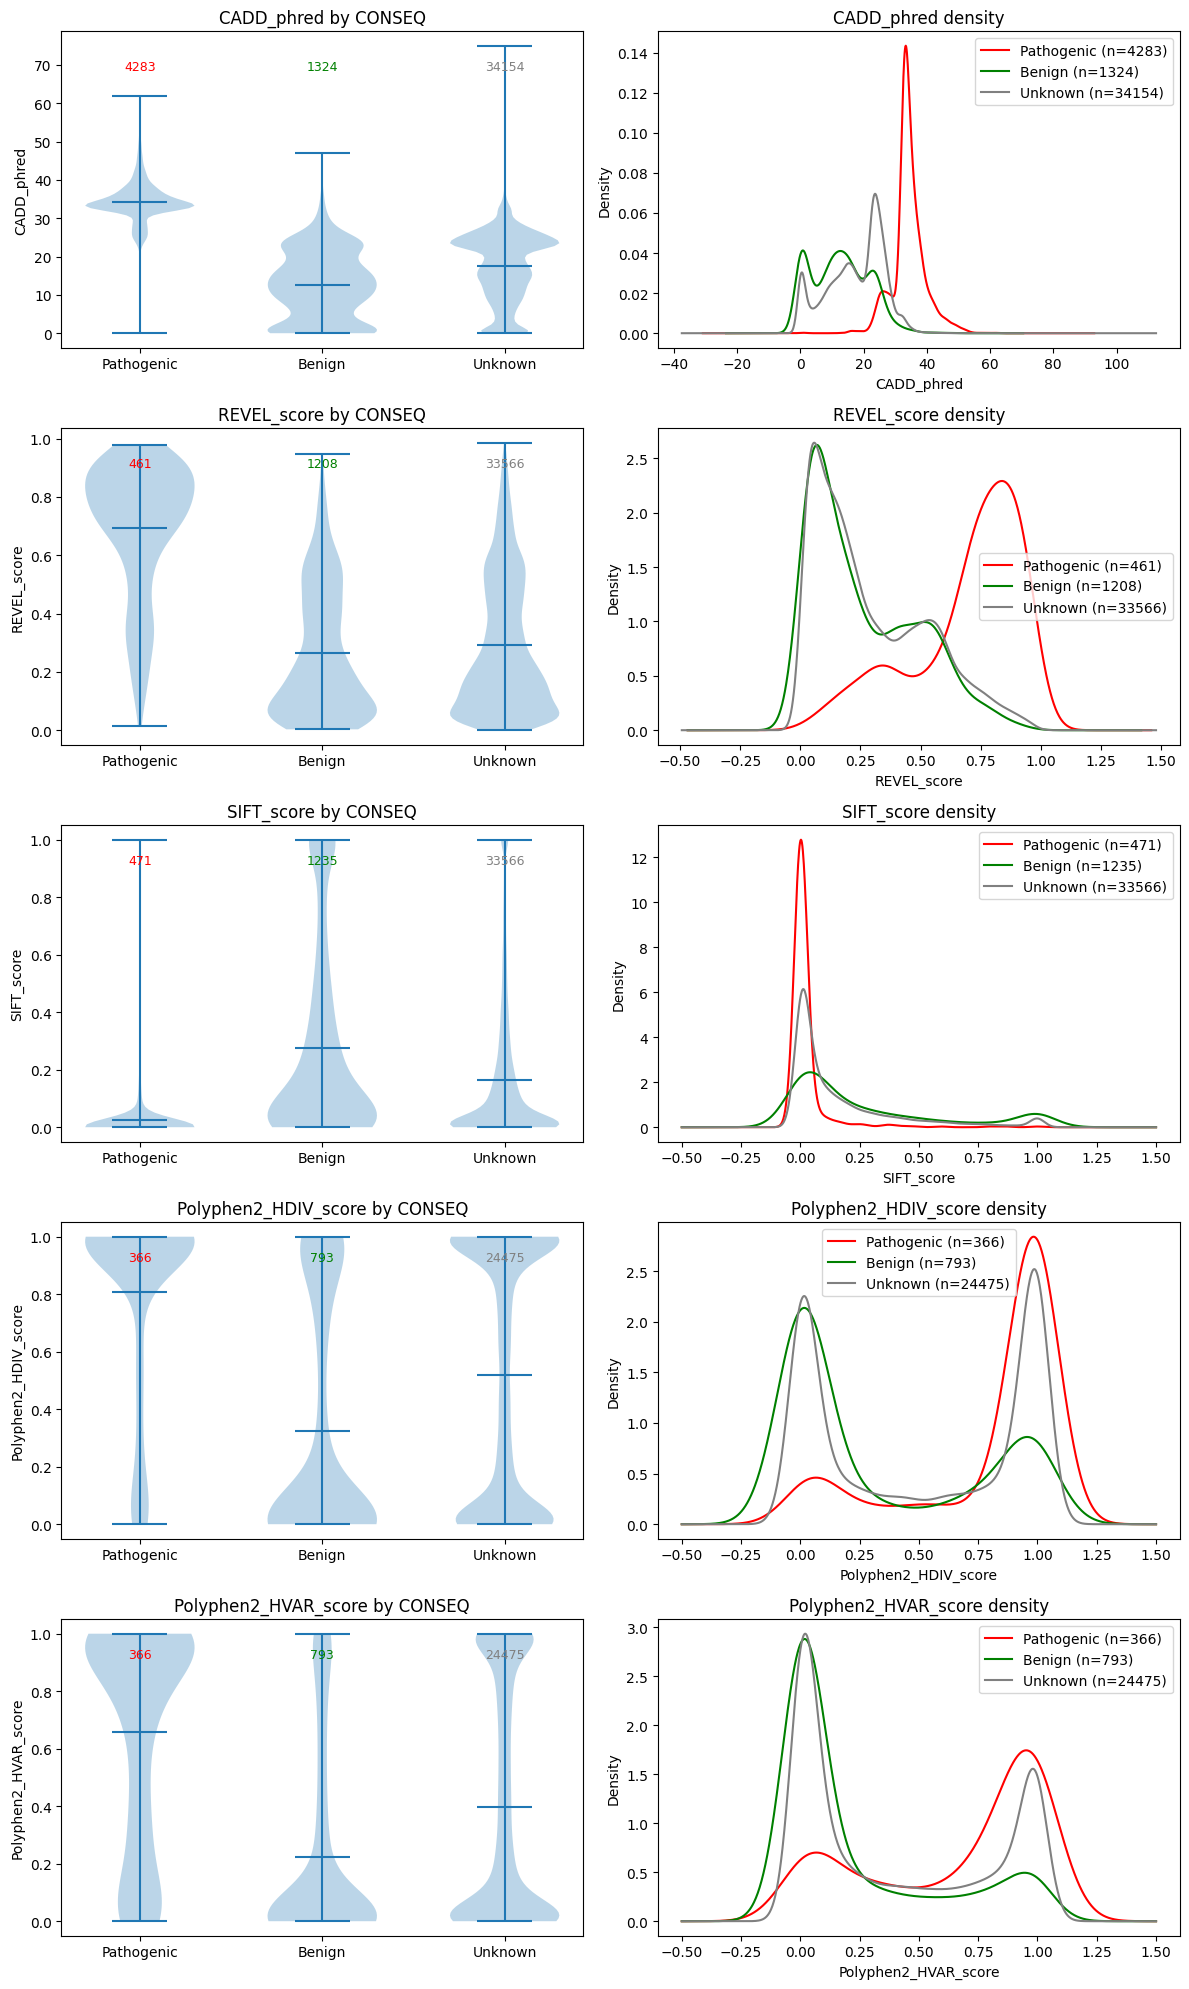

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure merged_df is defined in your environment before running this.

# Define CONSEQ categories and colors
categories = ['Pathogenic', 'Benign', 'Unknown']
colors = {'Pathogenic': 'red', 'Benign': 'green', 'Unknown': 'grey'}

# Subset to only those categories
df = merged_df[merged_df['CONSEQ'].isin(categories)].copy()
df['CONSEQ'] = pd.Categorical(df['CONSEQ'], categories=categories, ordered=True)

# Predictors to examine (ensure columns exist)
predictors = [c for c in ['CADD_phred', 'REVEL_score', 'SIFT_score',
                          'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score'] if c in df]

# Convert predictor columns to numeric once for all operations
for p in predictors:
    df[p] = pd.to_numeric(df[p], errors='coerce')

# Drop rows missing all predictors
df_clean = df.dropna(subset=predictors, how='all')

# Pre-compute maximum values to position the count labels
max_vals = {p: df_clean[p].max(skipna=True) or 1 for p in predictors}

# Create subplots: one row per predictor, two columns
n = len(predictors)
fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))
if n == 1:
    axes = np.array([axes])

for i, predictor in enumerate(predictors):
    ax_violin, ax_density = axes[i]

    # Data for each category
    data = [df_clean[df_clean['CONSEQ'] == cat][predictor].dropna() for cat in categories]

    # Violin plot
    ax_violin.violinplot(data, positions=range(len(categories)), showmeans=True, widths=0.6)
    ax_violin.set_xticks(range(len(categories)))
    ax_violin.set_xticklabels(categories)
    ax_violin.set_ylabel(predictor)
    ax_violin.set_title(f'{predictor} by CONSEQ')

    # Label counts above each violin
    for pos, cat in enumerate(categories):
        count = len(data[pos])
        y_pos = max_vals[predictor] * 0.95
        ax_violin.text(pos, y_pos, str(count), ha='center', va='top', fontsize=9, color=colors[cat])

    # Density plots
    for cat in categories:
        series = df_clean[df_clean['CONSEQ'] == cat][predictor].dropna()
        if not series.empty:
            series.plot.kde(ax=ax_density, label=f'{cat} (n={len(series)})', color=colors[cat])
    ax_density.set_title(f'{predictor} density')
    ax_density.set_xlabel(predictor)
    ax_density.legend()

plt.tight_layout()
plt.show()


Top domains by number of pathogenic variants:



,Pathogenic_Count
domain,
BRCT domain,3387
"Zinc finger, RING-type",1044
"Zinc finger, C3HC4 RING-type",522
"BRCA1, serine-rich domain",379
"DNA recombination and repair protein Rad51-like, C-terminal",304
"DNA recombination and repair protein RecA-like, ATP-binding domain",292
"Zinc finger, RING-type, conserved site",207
"Helicase superfamily 1/2, ATP-binding domain, DinG/Rad3-type",190
"Helicase superfamily 1/2, ATP-binding domain",178


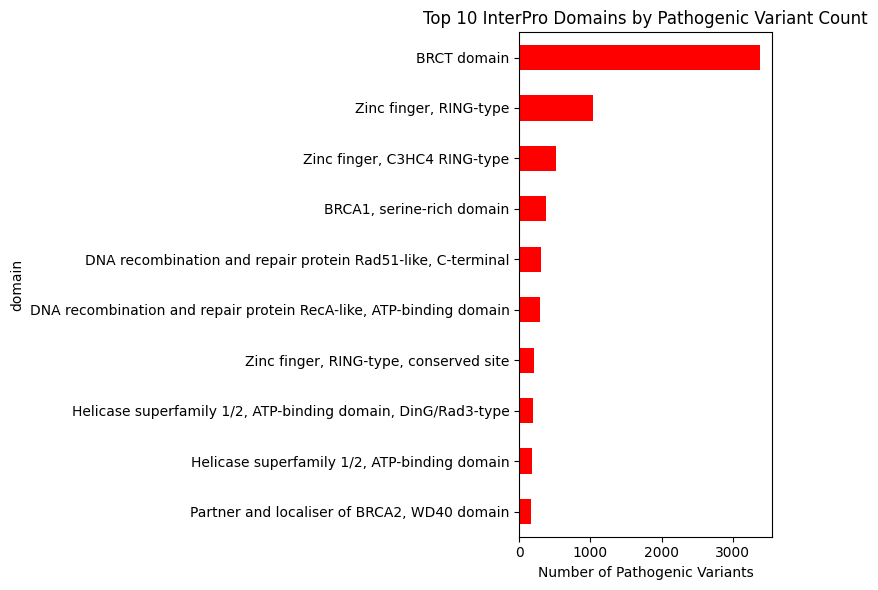

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure merged_df is loaded
if 'merged_df' not in globals():
    raise RuntimeError("Please load merged_df with 'Interpro_domain' and 'CONSEQ' before running this cell.")

# Step 1: Parse InterPro domains, splitting on '|' and ';' and exclude "." entries
df_domains = merged_df[['Interpro_domain', 'CONSEQ']].dropna(subset=['Interpro_domain', 'CONSEQ'])
df_domains['Interpro_domain'] = df_domains['Interpro_domain'].astype(str).str.replace(';', '|')
domain_exploded = df_domains.assign(domain=df_domains['Interpro_domain'].str.split('|')).explode('domain')

# Trim whitespace and exclude empty or "." tokens
domain_exploded['domain'] = domain_exploded['domain'].str.strip()
domain_exploded = domain_exploded[domain_exploded['domain'].notna() & (domain_exploded['domain'] != '') & (domain_exploded['domain'] != '.')]

# Step 2: Count Pathogenic variants per domain
grouped = domain_exploded.groupby(['domain', 'CONSEQUENCE'] if 'CONSEQUENCE' in domain_exploded.columns else ['domain','CONSEQ']).size().unstack(fill_value=0)
grouped = grouped.rename_axis(index='domain').rename_axis(columns=None)
if 'Pathogenic' not in grouped.columns:
    raise RuntimeError("No 'Pathogenic' column found in CONSEQ categories. Check standardized labels.")
pathogenic_counts = grouped['Pathogenic'].sort_values(ascending=False)

# Select top 10 domains
top_n = 10
top_domains = pathogenic_counts.head(top_n)

# Display the table of top domains
top_table = pd.DataFrame({'Pathogenic_Count': top_domains})
print("Top domains by number of pathogenic variants:\n")
display(top_table)

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
top_domains.plot(kind='barh', color='red')
plt.xlabel('Number of Pathogenic Variants')
plt.title(f'Top {top_n} InterPro Domains by Pathogenic Variant Count')
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()


In [ ]:
# prompt: sort exonic mutations non-synonymous by REPORTED, get top 3 pathogenic top 3 non pathogenic, and make sure the top 3 in each are of different genes, excluding FANCA, BRCA1 and BRCA2, return both as a tsv and add a column in the beginning for benign or patho

import pandas as pd

# Assuming merged_df is already defined and contains the necessary columns
# ... (your existing code) ...

def get_top_variants(df):
    """
    Filters and sorts exonic mutations, selects top pathogenic and benign variants,
    ensures unique genes, excludes specified genes.

    Args:
        df: Input DataFrame

    Returns:
        A DataFrame with the top variants, or None if the DataFrame doesn't meet requirements.
    """

    # Filter for exonic, non-synonymous mutations
    exonic_nonsynonymous = df[(df['Func.refGene'] == 'exonic') & (df['ExonicFunc.refGene'] != 'synonymous SNV')]


    # Exclude FANCA, BRCA1, and BRCA2 genes
    excluded_genes = ['FANCA', 'BRCA1', 'BRCA2']
    filtered_df = exonic_nonsynonymous[~exonic_nonsynonymous['gene'].isin(excluded_genes)]

    if filtered_df.empty:
        print("No variants found matching criteria.")
        return None

    # Sort by REPORTED
    filtered_df_sorted = filtered_df.sort_values('REPORTED', ascending=False)

    #Get top 3 pathogenic
    pathogenic_df = filtered_df_sorted[filtered_df_sorted['CONSEQ'] == 'Pathogenic'].groupby('gene').head(1).head(3)

    #Get top 3 non-pathogenic
    non_pathogenic_df = filtered_df_sorted[filtered_df_sorted['CONSEQ'] == 'Benign'].groupby('gene').head(1).head(3)

    #Combine and add column
    final_df = pd.concat([pathogenic_df,non_pathogenic_df])
    final_df['Classification'] = final_df['CONSEQ'].map({'Pathogenic':'Pathogenic','Benign':'Benign'})

    return final_df

# Get the top variants using the function
top_variants = get_top_variants(merged_df)

# Save to TSV file if variants were found
if top_variants is not None:
  top_variants.to_csv('top_variants.tsv', sep='\t', index=False)
  print("Top variants saved to 'top_variants.tsv'")


Top variants saved to 'top_variants.tsv'


In [ ]:
# prompt: unique ID values in merged_df, unique first 4 letters

# Assuming merged_df is already defined as in the provided code.

unique_ids = merged_df['ID'].unique()
print(f"Number of unique IDs in merged_df: {len(unique_ids)}")

first_four_letters = [id[:4] for id in unique_ids if isinstance(id, str) and len(id) >= 4]
unique_first_four = set(first_four_letters)
print(f"Number of unique first four letters of IDs: {len(unique_first_four)}")
print(f"Unique first four letters: {unique_first_four}")


Number of unique IDs in merged_df: 79385
Number of unique first four letters of IDs: 10
Unique first four letters: {'LOVD', 'CV.M', 'CV.X', 'CV.F', 'CV.S', 'CV.E', 'CV.B', 'CV.P', 'CV.R', 'CV.U'}


In [ ]:
merged_df.to_csv('merged_df.tsv', sep='\t', index=False)